In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot as plt
from collections import Counter


In [54]:
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
val = ds['validation']
test = ds['test']

In [5]:
print(train)

<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [6]:
for example in train.take(1):
    print(example)

{'audio': <tf.Tensor: shape=(16000,), dtype=int16, numpy=array([-15, -18, -12, ...,  16,  21,  25], dtype=int16)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=4>}


2024-07-04 16:43:10.040437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
def plot_label_distribution(dataset,title):
    # Step 1: Extract labels from the dataset
    labels = [element['label'].numpy() for element in dataset]

    # Step 2: Count the occurrences of each label
    label_counts = Counter(labels)

    # Get the labels and their counts
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    # Step 3: Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title, size=20)
    plt.show()

2024-07-04 16:43:13.481284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


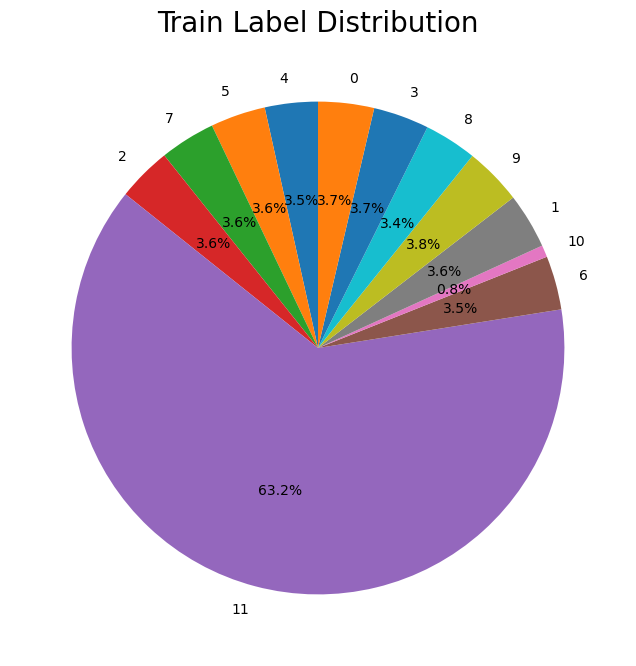

2024-07-04 16:43:14.019912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


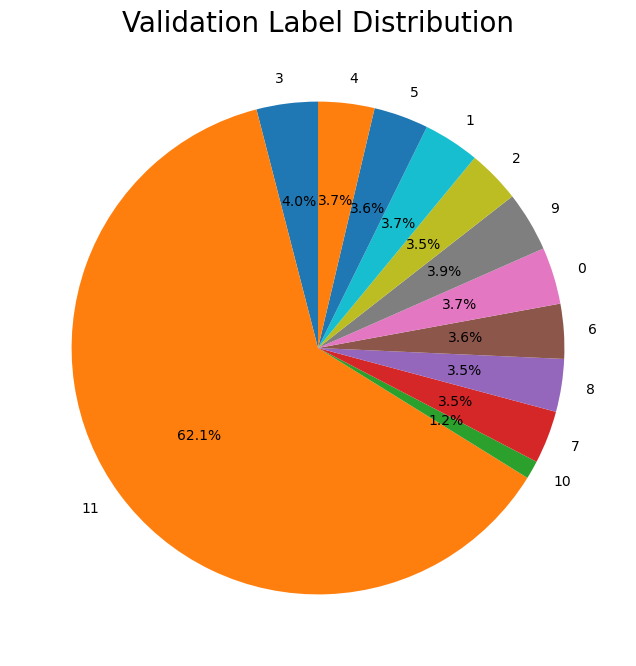

2024-07-04 16:43:14.359739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


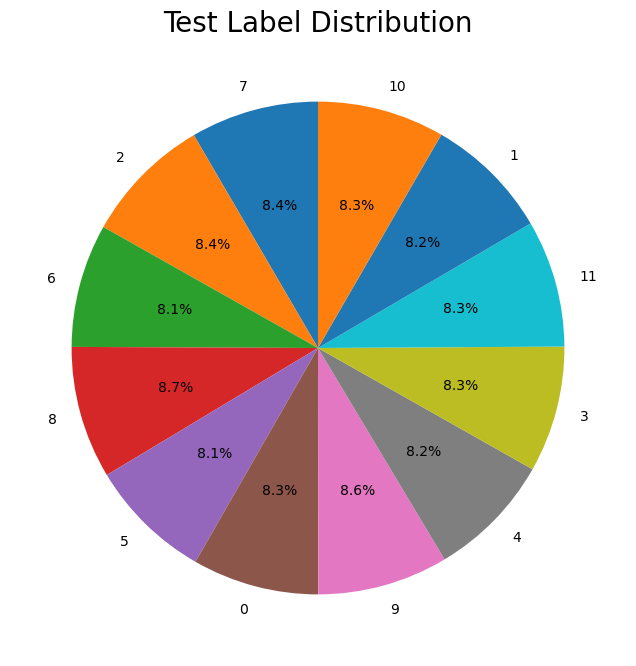

In [8]:
plot_label_distribution(train,'Train Label Distribution')
plot_label_distribution(val,'Validation Label Distribution')
plot_label_distribution(test,'Test Label Distribution')

In [9]:
def select_one_tensor_per_category(tensor_list):
    """
    Select one tensor from each category (label).
    
    Args:
    tensor_list (list of dict): A list where each element is a dictionary 
                                containing 'audio' and 'label' keys.
    
    Returns:
    list of dict: A list of selected tensors, one from each category.
    """
    category_dict = {}
    
    for item in tensor_list:
        audio = item['audio'] 
        label = item['label'].numpy()  # Convert to numpy for easier handling
        
        if label not in category_dict:
            category_dict[label] = audio
            
    selected_tensors = [{'audio': audio, 'label':tf.convert_to_tensor(label)} 
                        for label, audio in category_dict.items()]
    
    return selected_tensors


In [10]:
categorial_tensors = select_one_tensor_per_category(train)

2024-07-04 16:43:17.740032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
print(len(categorial_tensors))

12


In [12]:


def plot_signals_time(titles, signals):
    nrows, ncols = 2, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 6))

    z = 0
    for i in range(nrows):
        for y in range(ncols):
            ax[i, y].set_title(titles[z])
            ax[i, y].plot(signals[z])
            ax[i, y].set_xticks([])
            ax[i, y].set_yticks([])
            ax[i, y].grid(False)
            z += 1

    plt.show()

In [13]:
#sort categorial_tensors by label
categorial_tensors = sorted(categorial_tensors, key=lambda x: x['label'].numpy())

In [14]:
#get the labels,indexes from the dataset builder
info = tfds.builder(f'speech_commands:0.0.{version}').info
labels = info.features['label'].names
labels_index = info.features['label'].num_classes

In [15]:
#convert the labels to text
categorial_audio = [{'audio': item['audio'].numpy(), 'label':f'{i} ' + labels[item['label'].numpy()]} for i,item in enumerate(categorial_tensors)]

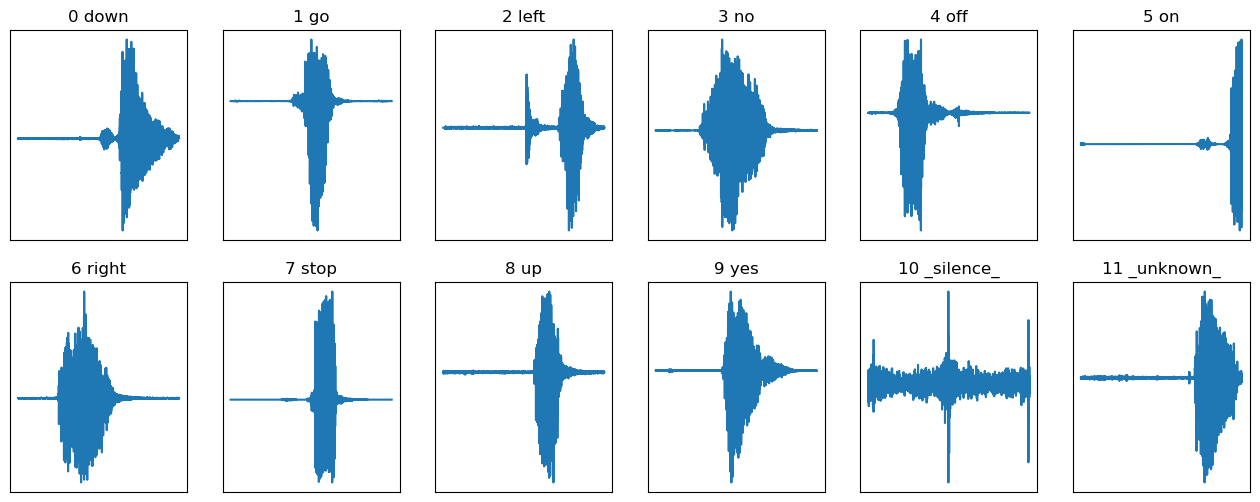

In [16]:
titles = [f'{item["label"]}' for item in categorial_audio]
signals = [item['audio'] for item in categorial_audio]
plot_signals_time(titles, signals)

In [17]:
#check that audio match the label
import IPython.display as ipd
for item in categorial_audio:
    print(item['label'])
    ipd.display(ipd.Audio(item['audio'], rate=16000))

0 down


1 go


2 left


3 no


4 off


5 on


6 right


7 stop


8 up


9 yes


10 _silence_


11 _unknown_


In [21]:
#create mel spectrogram using tfio
import tensorflow_io as tfio

def create_mel_spectrogram(audio):
    """
    Create a mel spectrogram from an audio tensor.
    
    Args:
    audio (tf.Tensor): A 1D tensor containing the audio samples.
    
    Returns:
    tf.Tensor: A 2D tensor containing the mel spectrogram.
    """
    audio = tf.cast(audio, tf.float32)
    # audio = tfio.audio.resample(audio, 16000, 8000)
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    audio = tf.signal.stft(audio, frame_length=255, frame_step=128)
    audio = tf.abs(audio)
    audio = tfio.audio.melscale(audio, rate=16000, mels=128, fmin=0, fmax=8000)
    audio = tf.math.log(audio + 1e-6)
    audio = tf.transpose(audio)
    
    return audio


In [22]:
mel_spectrograms = [create_mel_spectrogram(item['audio']).numpy() for item in categorial_tensors]

In [76]:
def plot_spectrogram(titles, signals, title, shape=(20, 10)):
    nrows, ncols = 2, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=shape)
    fig.suptitle(title, size=20)
    plt.set_cmap('viridis')

    z = 0
    for i in range(nrows):
        for y in range(ncols):
            ax[i, y].set_title(titles[z])
            ax[i, y].imshow(signals[z].squeeze())
            ax[i, y].set_xticks([])
            ax[i, y].set_yticks([])
            ax[i, y].grid(False)
            z += 1

    plt.show()

/var/folders/nr/ykp9ym8x5rx7j1fpkhs32n880000gn/T/ipykernel_64539/645326628.py:16: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(mfcc.T + np.finfo(float).eps)


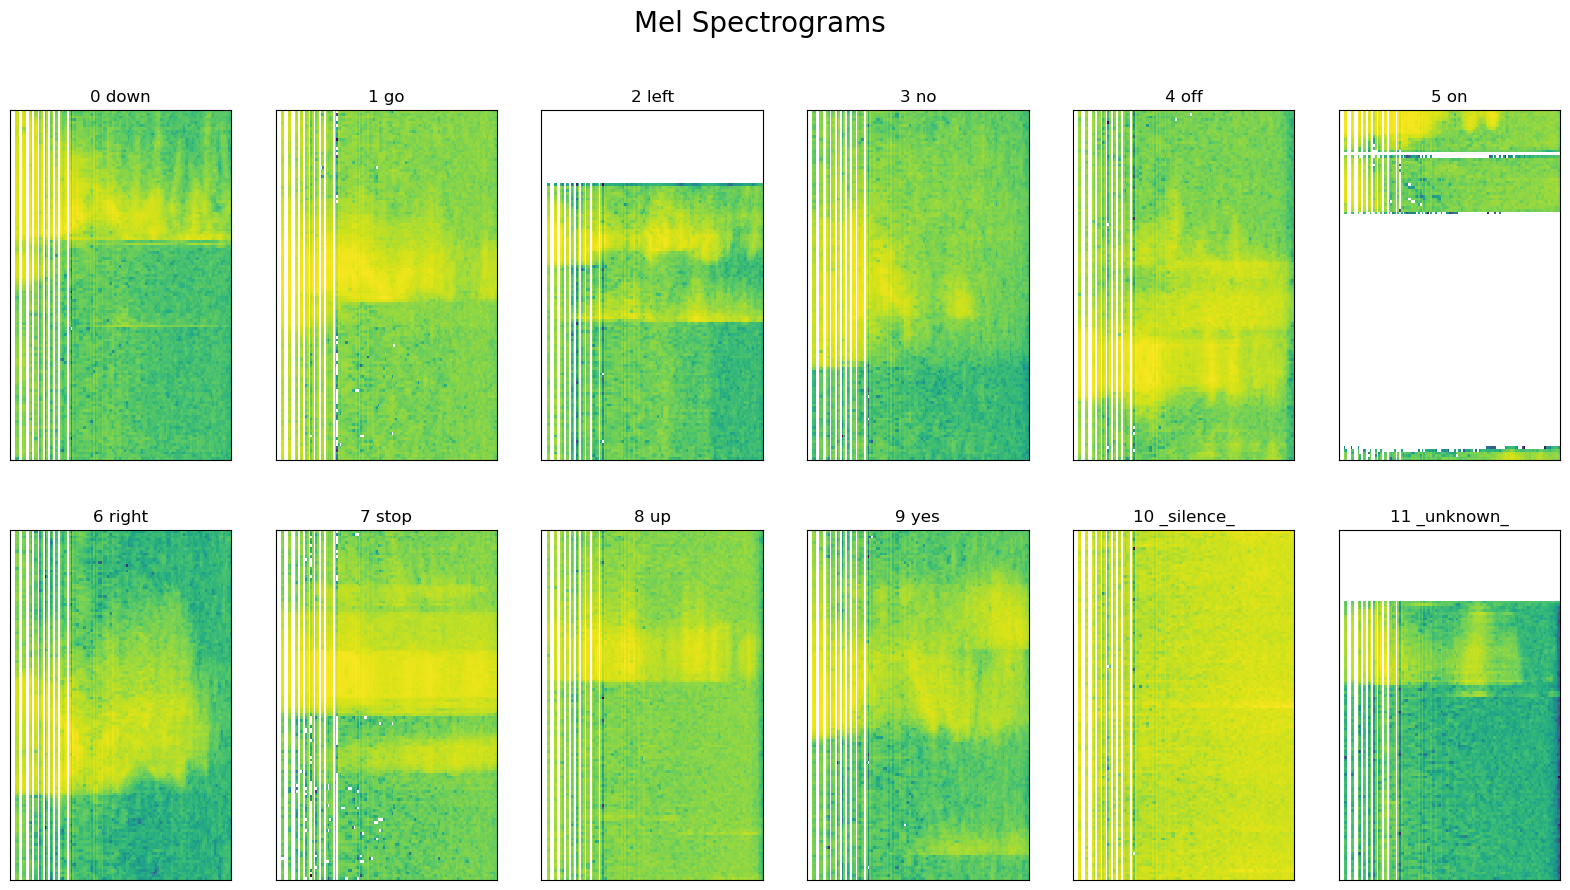

In [77]:
plot_spectrogram(titles, mel_spectrograms, 'Mel Spectrograms')

In [25]:
def create_MFCCs(audio):
    """
    Create MFCCs from an audio tensor.
    
    Args:
    audio (tf.Tensor): A 1D tensor containing the audio samples.
    
    Returns:
    tf.Tensor: A 2D tensor containing the MFCCs.
    """
    audio = tf.cast(audio, tf.float32)
    # audio = tfio.audio.resample(audio, 16000, 8000)
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    audio = tf.signal.stft(audio, frame_length=255, frame_step=128)
    audio = tf.abs(audio)
    audio = tfio.audio.melscale(audio, rate=16000, mels=128, fmin=0, fmax=8000)
    audio = tf.math.log(audio + 1e-6)
    audio = tf.transpose(audio)
    audio = tf.signal.mfccs_from_log_mel_spectrograms(audio)
    
    return audio

In [26]:
MFCCs = [create_MFCCs(item['audio']).numpy() for item in categorial_tensors]

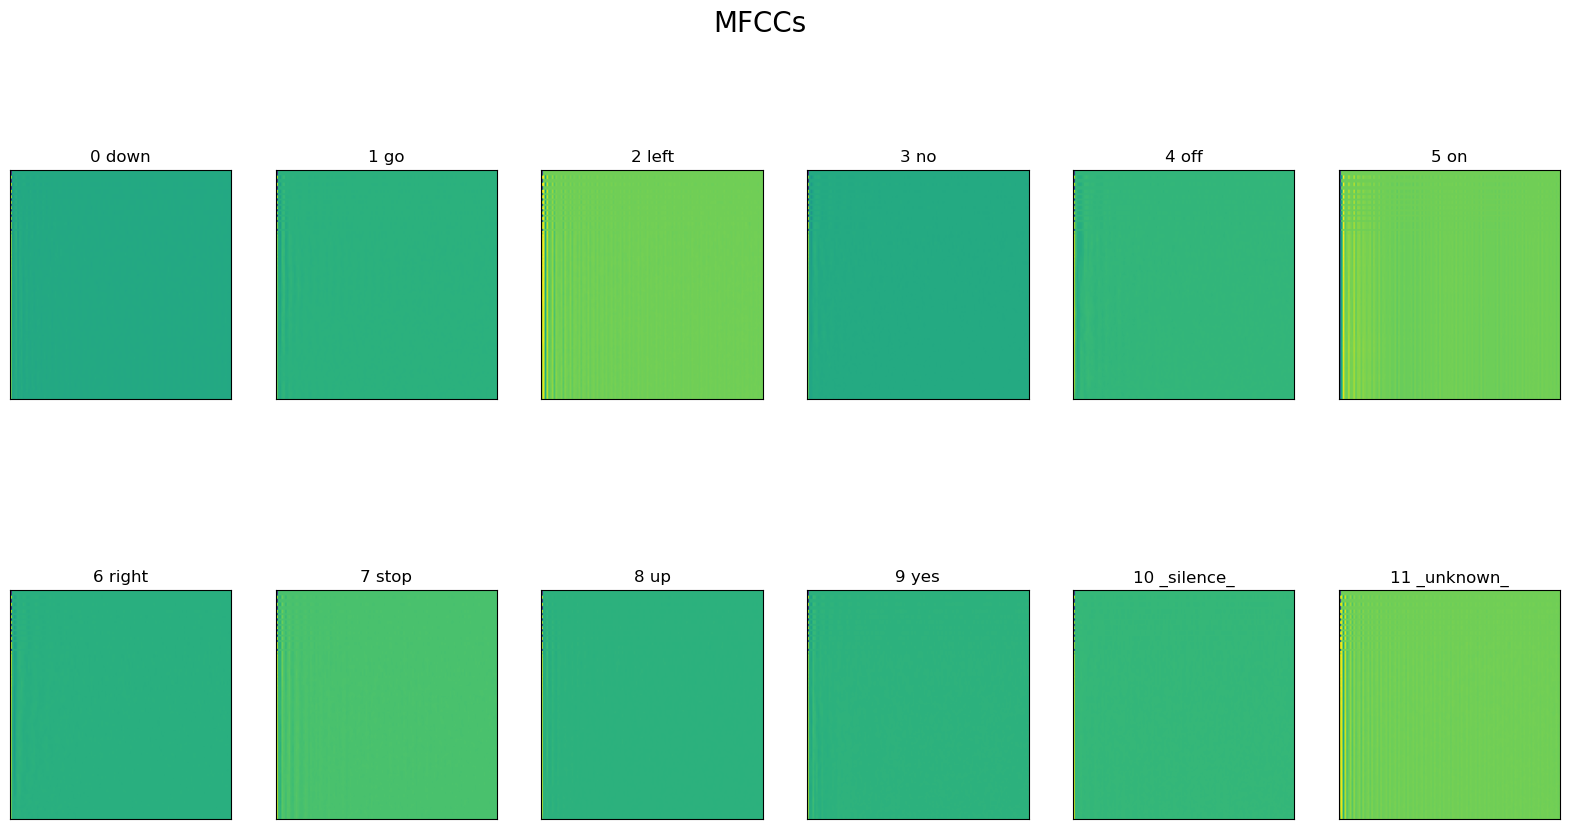

In [27]:
plot_spectrogram(titles, MFCCs, 'MFCCs', shape=(20, 10))

In [30]:
import numpy as np
from librosa.feature import melspectrogram

def create_mel_spectrogram_librosa(audio):
    """
    Create a mel spectrogram from an audio tensor using Librosa.
    
    Args:
    audio (tf.Tensor): A 1D tensor containing the audio samples.
    
    Returns:
    np.ndarray: A 2D numpy array containing the mel spectrogram.
    """
    audio = audio.numpy()
    mel_spectrogram = melspectrogram(y=audio, sr=16000, n_mels=128, fmin=0, fmax=8000)
    mel_spectrogram = np.log(mel_spectrogram + 1e-9)
    
    return mel_spectrogram

In [34]:
mel_spectrograms_librosa = [create_mel_spectrogram_librosa(tf.cast(item['audio'], tf.float32)) for item in categorial_tensors]

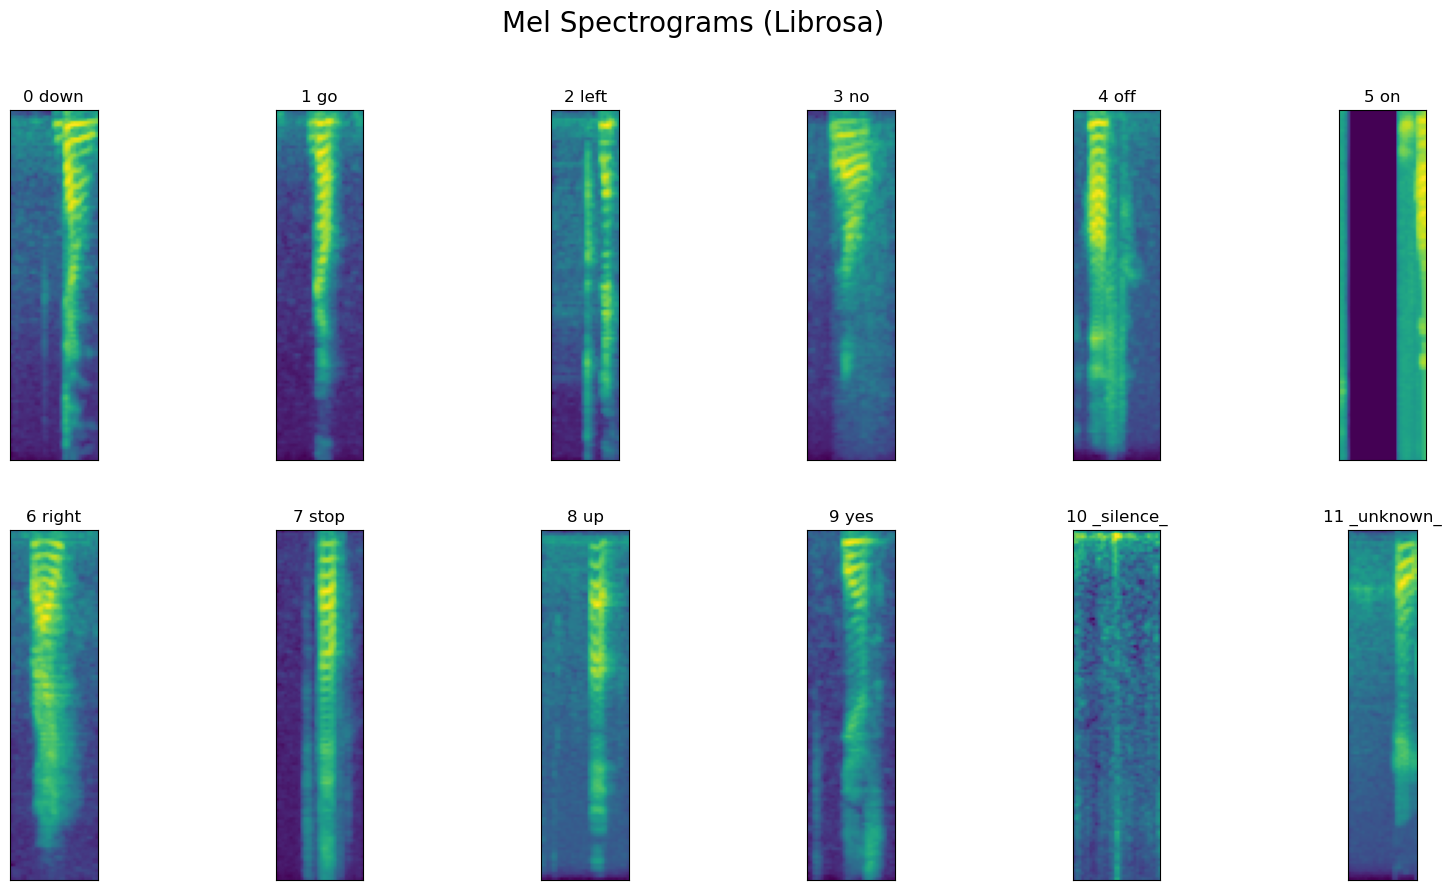

In [35]:
plot_spectrogram(titles, mel_spectrograms_librosa, 'Mel Spectrograms (Librosa)', shape=(20, 10))

In [46]:
from librosa.feature import mfcc

def create_MFCCs_librosa(audio):
    """
    Create MFCCs from an audio tensor using Librosa.
    
    Args:
    audio (tf.Tensor): A 1D tensor containing the audio samples.
    
    Returns:
    np.ndarray: A 2D numpy array containing the MFCCs.
    """
    audio = audio.numpy()
    # MFCCs = mfcc(y=audio, sr=16000, n_mfcc=13, n_mels=128, fmin=0, fmax=8000)
    MFCCs = mfcc(y=audio, sr=16000, n_mfcc=13, n_fft=400, hop_length=160, n_mels=40, fmin=0, fmax=8000)
    return MFCCs

In [47]:
MFCCs_librosa = [create_MFCCs_librosa(tf.cast(item['audio'], tf.float32)) for item in categorial_tensors]

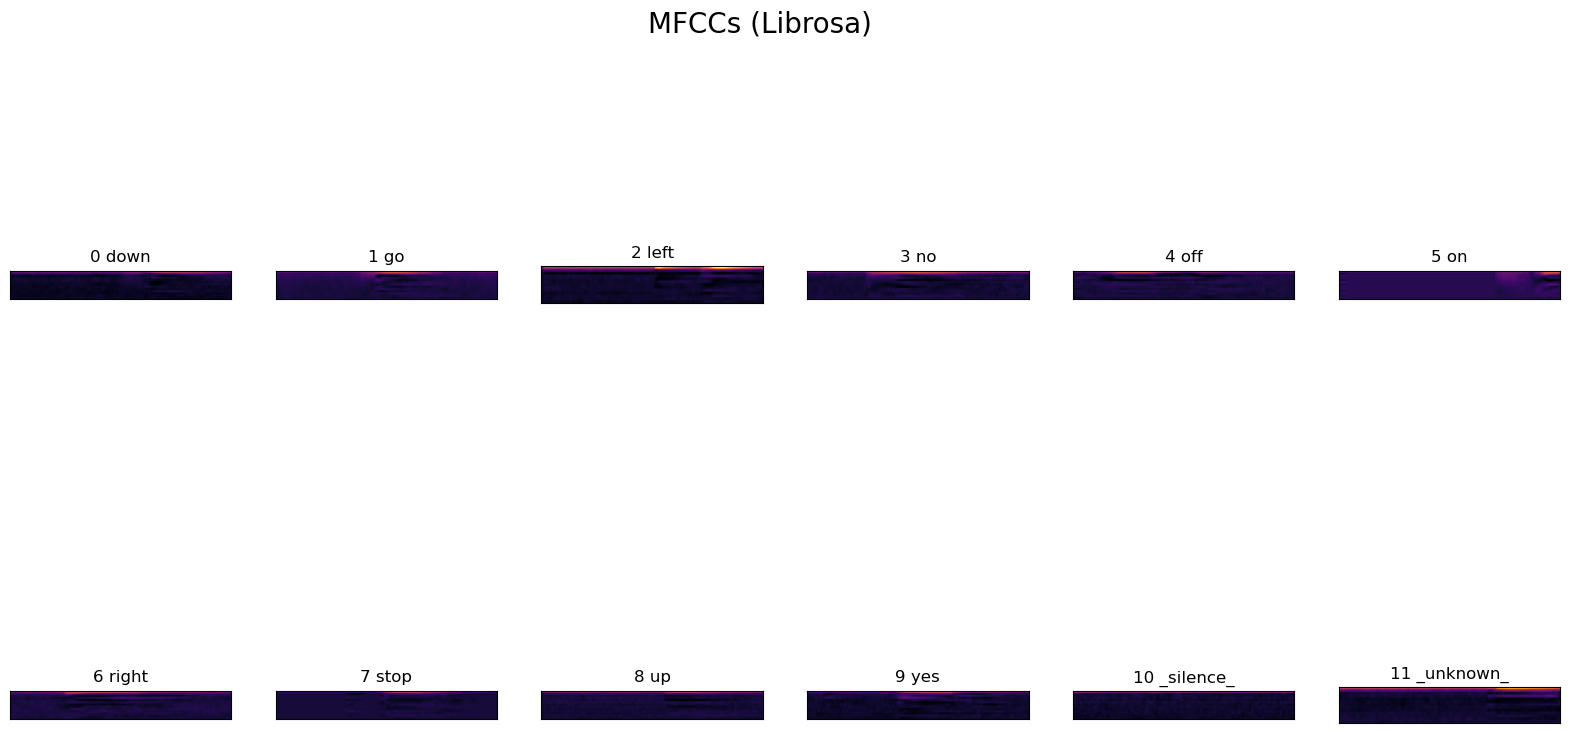

In [50]:
plot_spectrogram(titles, MFCCs_librosa, 'MFCCs (Librosa)', shape=(20, 10))

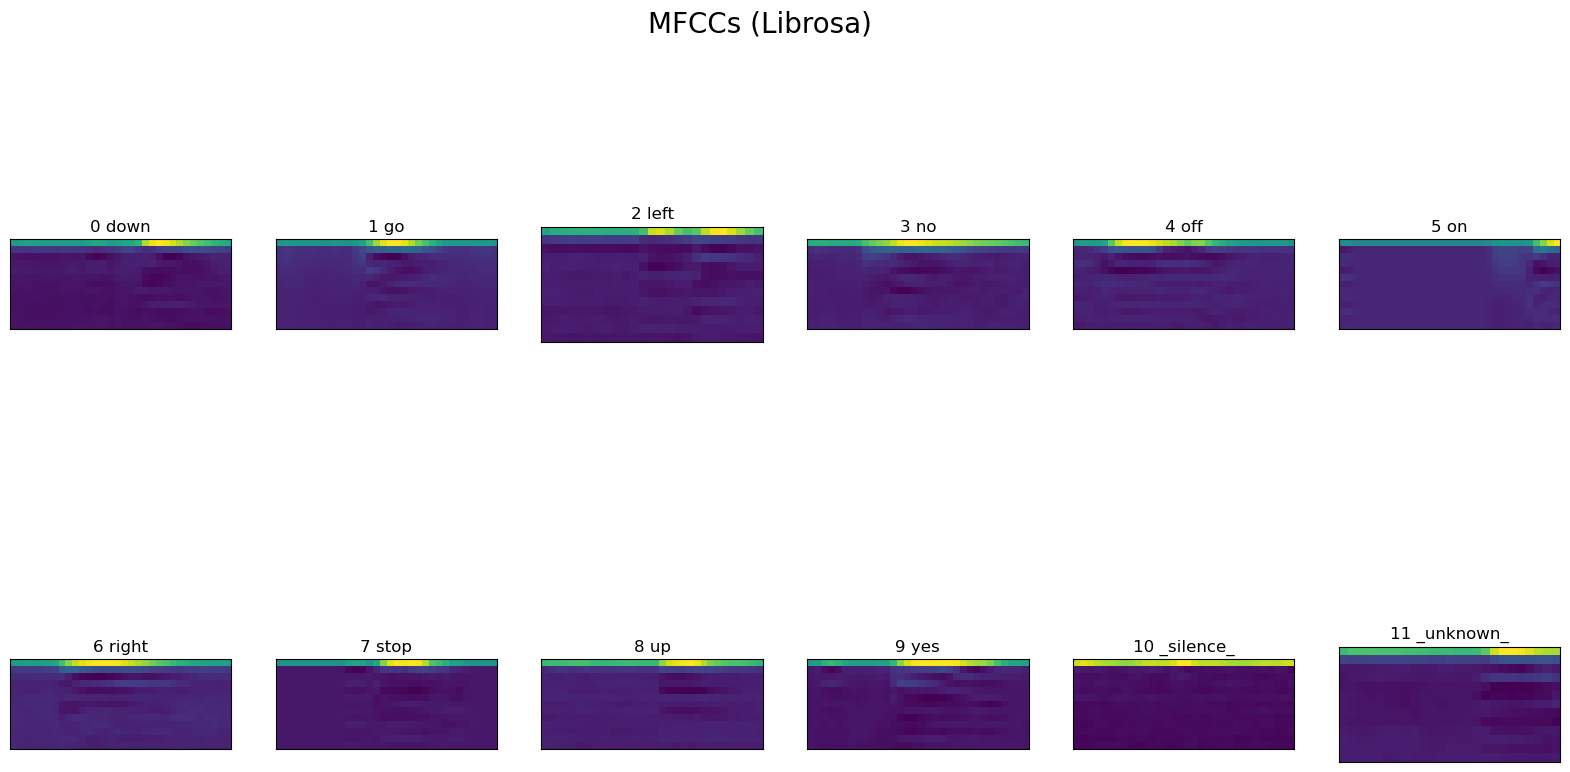

In [38]:
plot_spectrogram(titles, MFCCs_librosa, 'MFCCs (Librosa)', shape=(20, 10))

In [65]:
# custom MFCC function
# An integer representing the sampling rate.
sr = 16000
# An integer scalar Tensor. The window length in samples.
frame_length = int(sr/40) #25 ms
# An integer scalar Tensor. The number of samples to step.
frame_step = int(sr/100) #10 ms
# An integer scalar Tensor. The size of the FFT to apply.
fft_length = int(sr/40) #25 ms
# An integer representing the num of filterbanks.
num_feats = 40

def get_mfccs(
        audio,
        channels= 1,
        sample_rate= 16000,
        frame_length= 400,
        frame_step = 160,
        fft_length = 400,
        num_feats = 40
    ):
    audio = tf.cast(audio, tf.float32)

    stfts = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0 , sample_rate/2, num_feats
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)
    mfccs = mfccs[..., tf.newaxis]

    return mfccs

# Preprocessing function
def preprocess(example):
    audio = example['audio']
    label = example['label']
    mfccs = get_mfccs(audio)
    return mfccs, label

In [81]:
MFCCS_custom = [get_mfccs(item['audio']).numpy() for item in categorial_tensors]

In [85]:
# try new plot function specifically for MFCCs
def plot_MFCCs(titles, signals, title, shape=(20, 10)):
    nrows, ncols = 2, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=shape)
    fig.suptitle(title, size=20)
    plt.set_cmap('viridis')

    z = 0
    for i in range(nrows):
        for y in range(ncols):
            if z < len(signals):
                ax[i, y].set_title(titles[z])
                mfcc = signals[z]
                if len(mfcc.shape) > 2:
                    mfcc = np.squeeze(mfcc, axis=-1)
                # Convert the frequencies to log scale and transpose
                log_spec = np.log(mfcc.T + np.finfo(float).eps)
                height = log_spec.shape[0]
                width = log_spec.shape[1]
                X = np.linspace(0, np.size(mfcc), num=width, dtype=int)
                Y = range(height)
                ax[i, y].pcolormesh(X, Y, log_spec)
                ax[i, y].set_xticks([])
                ax[i, y].set_yticks([])
                ax[i, y].grid(False)
                z += 1
            else:
                ax[i, y].axis('off')  # Hide empty subplots

    plt.show()

/var/folders/nr/ykp9ym8x5rx7j1fpkhs32n880000gn/T/ipykernel_64539/2786809578.py:16: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(mfcc.T + np.finfo(float).eps)


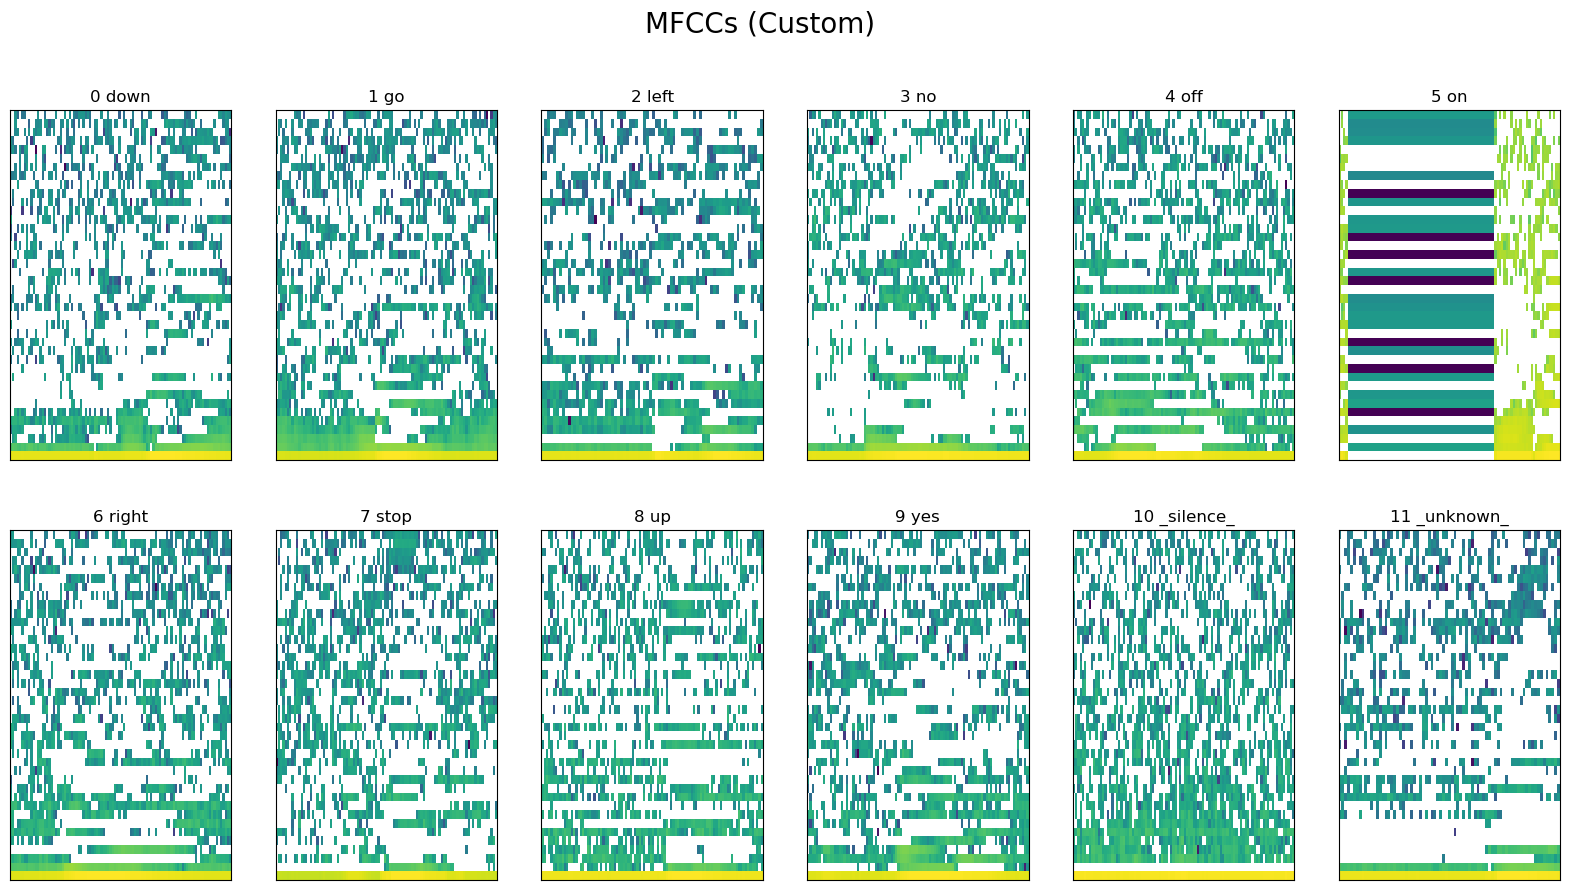

In [83]:
plot_MFCCs(titles, MFCCS_custom, 'MFCCs (Custom)', shape=(20, 10))

/var/folders/nr/ykp9ym8x5rx7j1fpkhs32n880000gn/T/ipykernel_64539/2786809578.py:16: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(mfcc.T + np.finfo(float).eps)


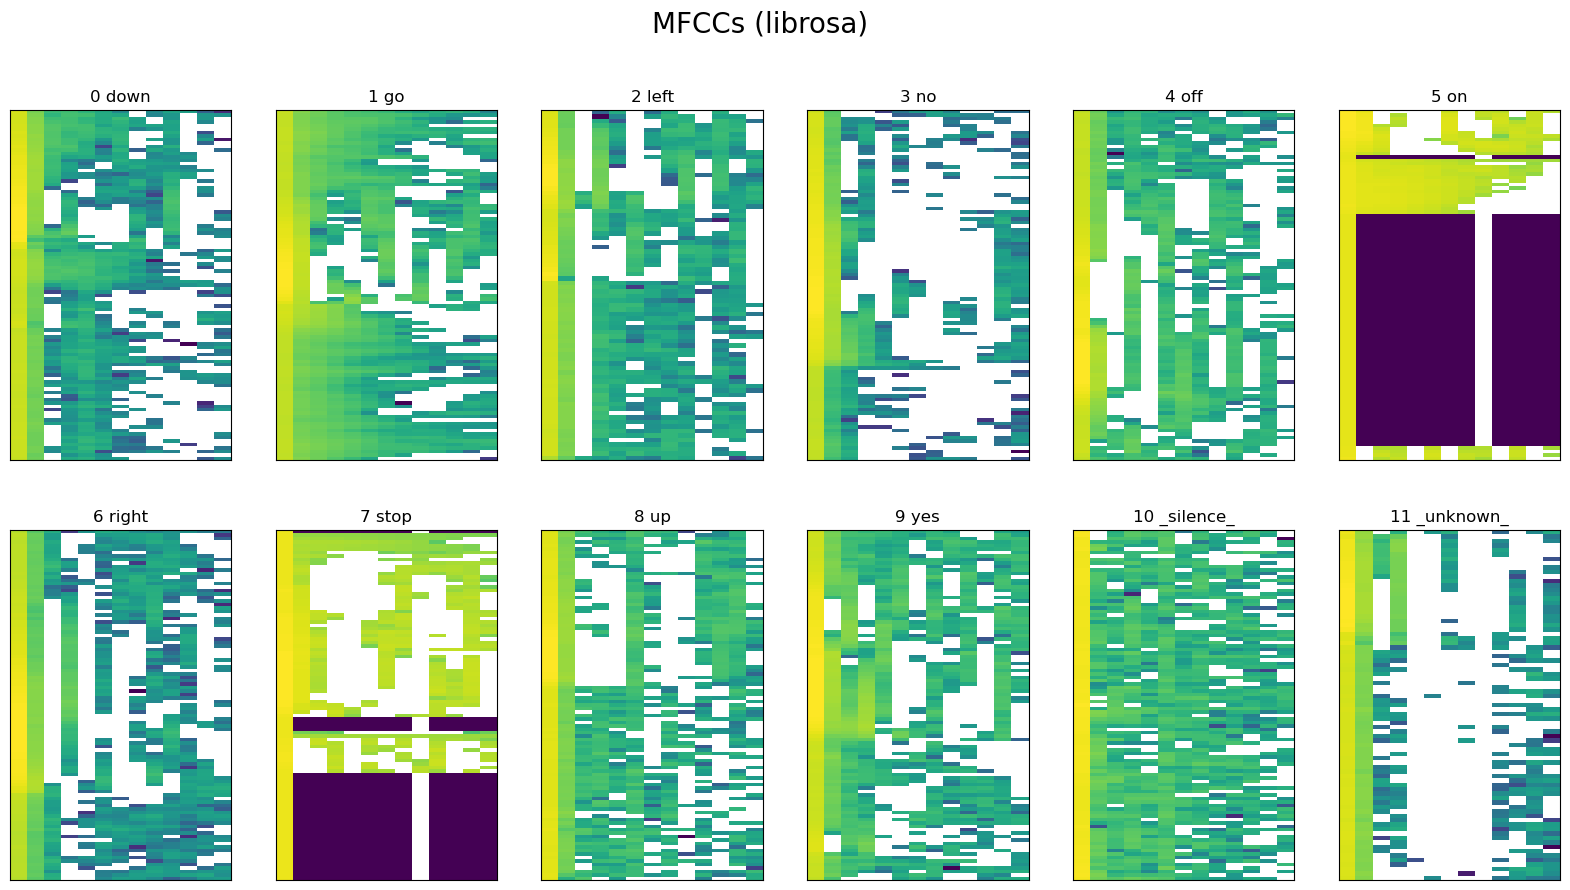

In [84]:
plot_MFCCs(titles, MFCCs_librosa, 'MFCCs (librosa)', shape=(20, 10))

/var/folders/nr/ykp9ym8x5rx7j1fpkhs32n880000gn/T/ipykernel_64539/3951518447.py:17: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(mfcc.T + np.finfo(float).eps)


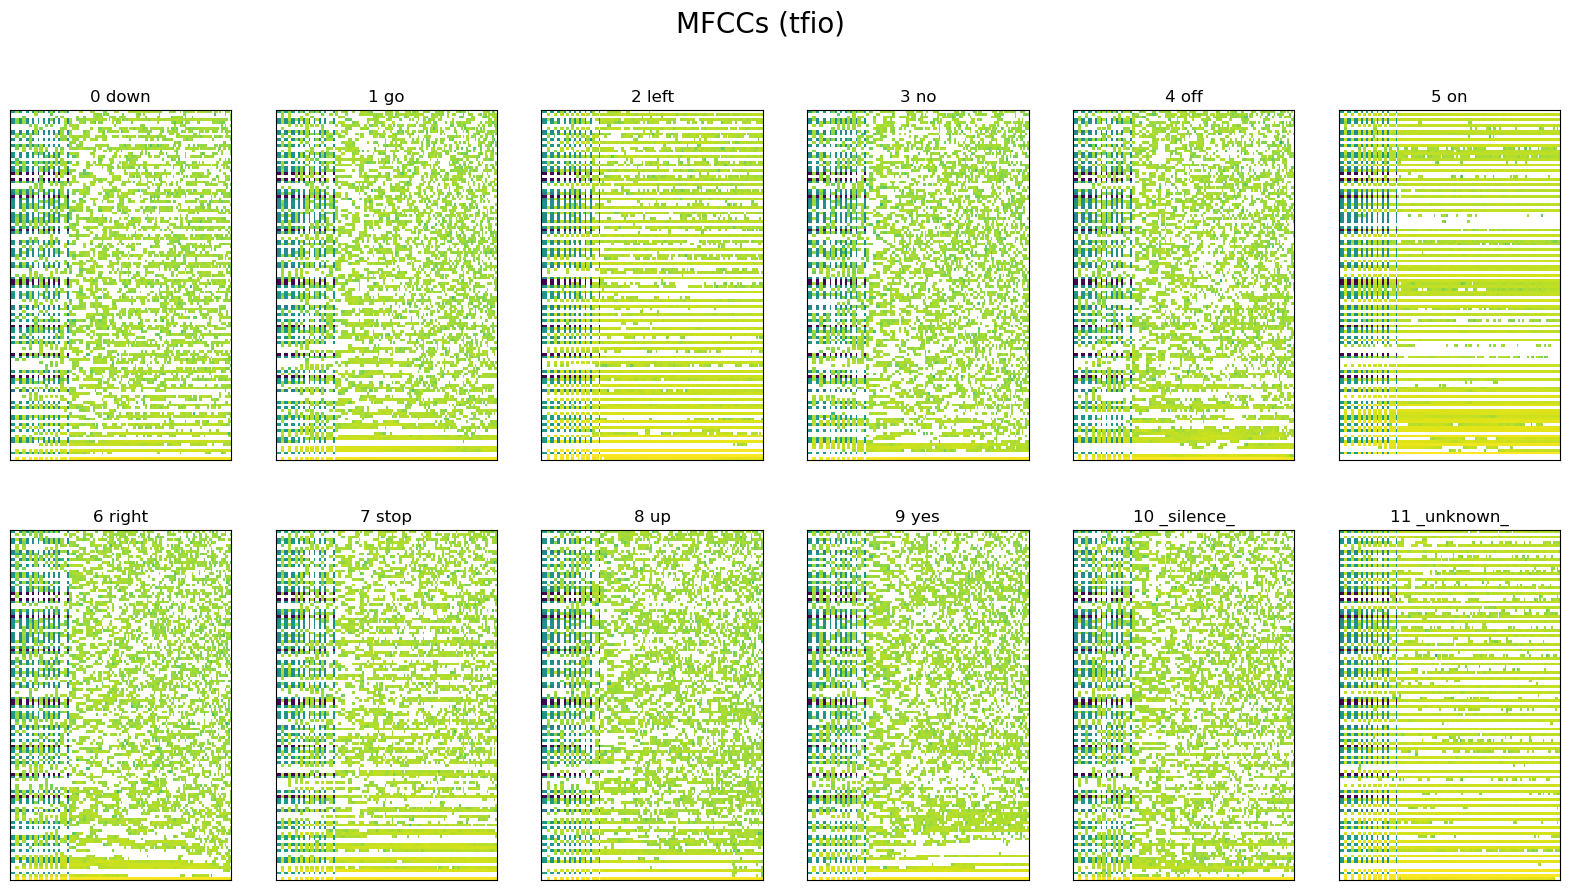

In [86]:
plot_MFCCs(titles, MFCCs, 'MFCCs (tfio)', shape=(20, 10))